<a href="https://colab.research.google.com/github/coldfir3/KAGGLE-SETI/blob/main/Seti%20V4.0%20(VideoTransformer).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initial Setup

In [1]:
import sys
import os
is_colab = 'google.colab' in sys.modules
!nvidia-smi

Mon Aug 16 01:42:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:0A:00.0  On |                  N/A |
| 44%   51C    P8    37W / 260W |    686MiB / 10997MiB |      7%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Installing packages

In [2]:
if is_colab:
    !pip install -Uqqq wandb
    !pip install -Uqqq fastai
    !pip install -Uqqq timm

### Loading packages

In [3]:
from fastai.vision.all import *
import wandb
from fastai.callback.wandb import *
from argparse import Namespace
import timm

### Downloading data



In [4]:
wandb.Api()
if is_colab:

    from google.colab import drive
    from os.path import exists

    if not exists('/content/drive'):
        drive.mount('/content/drive')
    %run '/content/drive/MyDrive/Kaggle/My Kaggle [colab].ipynb'

    if not exists('/content/train/'):
        setup_kaggle()
        get_kaggle_data('d', 'coldfir3/seti-spatial-dataset-v3')
        ! kaggle competitions download -c seti-breakthrough-listen -f train_labels.csv

## Setting up the DataFrames

In [5]:
from sklearn.model_selection import StratifiedKFold
if is_colab: 
    base_path = '/content/train/'
    train_df = pd.read_csv('/content/train_labels.csv.zip')
else:
    base_path = '/media/passos/Data/DSET/seti-spatial-dataset-v3/train/'
    train_df = pd.read_csv('/media/passos/Data/DSET/seti-spatial-dataset-v3/train_labels.csv.zip')

# train_df = train_df.sample(n=10_000).reset_index(drop=True)
train_df['fold'] = -1
train_df['path'] = train_df['id'].apply(lambda x: base_path + x + '.png')
train_df['label'] = train_df['target'].apply(lambda x: 'alien' if x == 1 else 'no-alien')
skf = StratifiedKFold(n_splits = 6, random_state = 42, shuffle = True)
for fold, (train_index, test_index) in enumerate(skf.split(train_df['id'], train_df['target'])):
    train_df.loc[test_index, 'fold'] = fold
train_df

,id,target,fold,path,label
0,0000799a2b2c42d,0,3,/media/passos/Data/DSET/seti-spatial-dataset-v3/train/0000799a2b2c42d.png,no-alien
1,00042890562ff68,0,3,/media/passos/Data/DSET/seti-spatial-dataset-v3/train/00042890562ff68.png,no-alien
2,0005364cdcb8e5b,0,4,/media/passos/Data/DSET/seti-spatial-dataset-v3/train/0005364cdcb8e5b.png,no-alien
3,0007a5a46901c56,0,3,/media/passos/Data/DSET/seti-spatial-dataset-v3/train/0007a5a46901c56.png,no-alien
4,0009283e145448e,0,3,/media/passos/Data/DSET/seti-spatial-dataset-v3/train/0009283e145448e.png,no-alien
...,...,...,...,...,...
59995,fff8217fe05aba3,0,4,/media/passos/Data/DSET/seti-spatial-dataset-v3/train/fff8217fe05aba3.png,no-alien
59996,fffa939e610ed70,0,4,/media/passos/Data/DSET/seti-spatial-dataset-v3/train/fffa939e610ed70.png,no-alien
59997,fffbb1c9c3d6c31,1,5,/media/passos/Data/DSET/seti-spatial-dataset-v3/train/fffbb1c9c3d6c31.png,alien
59998,fffc9a763d23647,0,0,/media/passos/Data/DSET/seti-spatial-dataset-v3/train/fffc9a763d23647.png,no-alien


## DataBlock & DataLoader

In [6]:
import albumentations as A
class AlbumentationsTransform(Transform):
    split_idx = 0
    def __init__(self, aug): self.aug = aug
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)
tfms = A.Compose([
        A.HorizontalFlip(p=.5),
        A.VerticalFlip(p=.5),
        A.ShiftScaleRotate(rotate_limit=0, p=.25),
        A.MotionBlur(p=.2),
        A.IAASharpen(p=.25)
])

/home/passos/anaconda3/lib/python3.8/site-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)


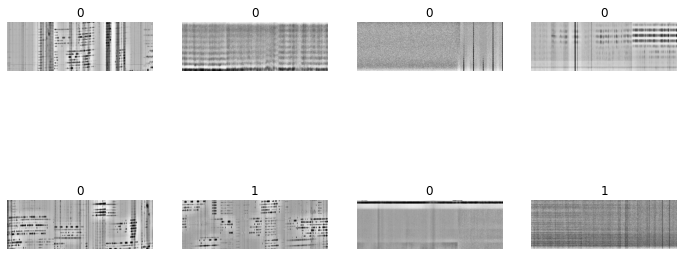

In [7]:
def get_dls(df, **config):
    is_colab = 'google.colab' in sys.modules
    workers = 2 if is_colab else 10
    splitter = IndexSplitter(df[df.fold == config['fold']].index)
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock()),
        splitter = splitter,
        getters=[ColReader('path'), ColReader('target')],
        item_tfms=[Resize((224, 224*3), method = 'sqish'), AlbumentationsTransform(tfms)],
        batch_tfms=[Flip(), Normalize(mean = tensor(0.5), std = tensor(0.177))]
        ).dataloaders(df, bs = config['bs'], num_workers = workers)

dls = get_dls(train_df, **{'bs':8, 'fold':0})
dls.show_batch()

## Playground

In [8]:
from timesformer.models.vit import TimeSformer

In [9]:
model = TimeSformer(img_size=224, num_classes=1, num_frames=3, attention_type='divided_space_time',  pretrained_model='/home/passos/Downloads/TimeSformer_divST_8x32_224_K400.pyth')
dummy_video = torch.randn(2, 3, 8, 224, 224) # (batch x channels x frames x height x width)
model(dummy_video) # (2, 1)

tensor([[0.3197],
        [0.1513]], grad_fn=<AddmmBackward>)

In [10]:
xb, yb = dls.one_batch()

In [11]:
xb = torch.split(xb.unsqueeze(1), 224, dim = -1)
xb = torch.cat(xb, dim = 2)
xb = torch.cat([xb] * 3, dim = 1)
xb.shape

torch.Size([8, 3, 3, 224, 224])

In [12]:
model(xb.cpu())

tensor([[ 0.0508],
        [ 0.6917],
        [ 0.8910],
        [ 0.5006],
        [-0.0368],
        [ 0.4828],
        [ 0.4892],
        [ 0.3487]], grad_fn=<AddmmBackward>)

## Training


In [13]:
class Img2Video(Callback):
    def before_batch(self):
        xb = self.learn.xb[0]
        xb = torch.split(xb.unsqueeze(1), 224, dim = -1)
        xb = torch.cat(xb, dim = 2)
        xb = torch.cat([xb] * 3, dim = 1)
        self.learn.xb = tuple([xb])

In [14]:
# learn = Learner(dls, model, loss_func=BCEWithLogitsLossFlat(), cbs = Img2Video())

In [15]:
# learn.fit_one_cycle(1, 1e-3)

In [16]:
class SaveAndLogBestModel(SaveModelCallback):

    def __init__(self, mon='valid_loss', **kwargs):
        super().__init__(monitor = mon, fname = mon, **kwargs)

    def _save(self, name): 
        self.last_saved_path = self.learn.save(name, with_opt=self.with_opt)
        self.model_path = Path(*list(self.last_saved_path.parts[:-1])) / (self.fname + '.pth')
        self.metadata = {n:s for n,s in zip(self.recorder.metric_names, self.recorder.log) if n not in ['time']}

    def after_fit(self, **kwargs):
        metadata = self.metadata
        for k,v in metadata.items(): metadata[k] = str(v)
        name = f'run_{wandb.run.id}_model'
        artifact_model = wandb.Artifact(name=name, type='model', metadata=metadata, description='trained model')
        with artifact_model.new_file(name, mode='wb') as fa:
            fa.write(self.model_path.read_bytes())
        wandb.run.log_artifact(artifact_model, aliases = [f'best {self.fname}', f'epoch {metadata["epoch"]}'])

In [17]:
class wandb_learner():

    def __init__(self, df, **config):

        cbs = []
        if config['Fit']['n_epoch'] < 1:
            df = df.sample(frac=config['Fit']['n_epoch']).reset_index(drop=True)
            config['Fit']['n_epoch'] = 1
            
        self.df = df
        self.config = config

        self.dls = get_dls(df, **config['Dataloader'])
        # if isinstance(config['Model'], Module):
        self.model = config.pop('Model')
        # else : print('error')
        self.learn = Learner(self.dls, self.model, **config['Learner']).add_cbs(cbs)

        self.scheduler = self.config['Fit'].pop('scheduler')
        self.wandb_config = self.config.pop('WandB')

    def unfrozen_count(self):
        return sum([np.prod(p.size()) for p in filter(lambda p: p.requires_grad, self.model.parameters())])

    def fit(self):

        if self.scheduler == 'fine_tune':

            lr_max  = self.config['Fit'].pop('lr_max')
            n_epoch = self.config['Fit'].pop('n_epoch')
            freeze_lr = self.config['Fit'].pop('freeze_lr')
            freeze_epochs = self.config['Fit'].pop('freeze_epochs')
            lr_mult = self.config['Fit'].pop('lr_mult')
            lr = slice(lr_max/lr_mult, lr_max)

            self.learn.freeze()
            print(f'Training {self.unfrozen_count()} parameters ...')
            self.learn.fit_one_cycle(freeze_epochs, slice(freeze_lr), pct_start=0.99, **self.config['Fit'])
            
            self.learn.unfreeze()
            print(f'Training {self.unfrozen_count()} parameters ...')
            self.learn.fit_one_cycle(n_epoch - freeze_epochs, lr, pct_start=0.3, div=5.0, **self.config['Fit'])    
            
            self.config['Fit']['lr_max'] = lr_max
            self.config['Fit']['n_epoch'] = n_epoch
            self.config['Fit']['freeze_lr'] = freeze_lr
            self.config['Fit']['freeze_epochs'] = freeze_epochs
            self.config['Fit']['lr_mult'] = lr_mult
            
        elif self.scheduler == 'one_cycle': 
          print(f'Training {self.unfrozen_count()} parameters ...')
          self.learn.fit_one_cycle(**self.config['Fit'])

        elif self.scheduler == 'cossine': print('not implemented')

        elif self.scheduler == 'reduce_on_plateau': print('not implemented')

        else: self.learn.fit(**self.config['Fit'])

    def wandb_fit(self):
        
        with wandb.init(config = self.config, **self.wandb_config) as run:
            self.learn.add_cb(WandbCallback(log=None, log_preds=False, log_model=False))
            self.learn.add_cb(SaveAndLogBestModel())
            self.fit()

def my_splitter(m):
    return [params(m)[:-2], params(m)[-2:]]

In [18]:
CFG = {
    'WandB' : {
        'project' : 'Seti V1',
        'tags': ['transformer', 'Video'],
        'notes':
        """
        """,
    },
    'Dataloader' : {
        'bs' : 8,
        'fold' : 0, 
    },
    'Model' : TimeSformer(img_size=224, num_classes=1, num_frames=3, attention_type='divided_space_time',  pretrained_model='/home/passos/Downloads/TimeSformer_divST_8x32_224_K400.pyth'),
    'Learner' : {
        'loss_func' : BCEWithLogitsLossFlat(),
        'metrics' : RocAucMulti(),
        'cbs' : [Img2Video(),
                 GradientAccumulation(32),
                #  MixUp()
                ],
        'splitter' : my_splitter,
      },
    'Fit' : {
        'scheduler' : 'fine_tune',
        'lr_max' : 0.005,
        'n_epoch' : 10,
        'freeze_lr' : 0.010,
        'freeze_epochs' : 1,
        'lr_mult' : 100,
    }
}

learn = wandb_learner(train_df, **CFG)
# learn.learn.lr_find()
learn.wandb_fit()
# learn.fit()

wandb: Currently logged in as: coldfir3 (use `wandb login --relogin` to force relogin)


Training 57601 parameters ...


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.310608,0.267109,0.732152,43:22


Better model found at epoch 0 with valid_loss value: 0.2671090364456177.
Training 121255681 parameters ...


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.251794,0.249491,0.752241,55:07
1,0.280587,0.268624,0.737547,54:58
2,0.207032,0.248674,0.777277,54:59
3,0.242566,0.249797,0.778489,54:59
4,0.209064,0.230238,0.784909,54:58
5,0.218874,0.220373,0.794081,54:58
6,0.227159,0.215809,0.804958,54:56
7,0.221667,0.212012,0.810934,54:56
8,0.202126,0.211614,0.811892,55:15


Better model found at epoch 0 with valid_loss value: 0.24949096143245697.
Better model found at epoch 2 with valid_loss value: 0.24867390096187592.
Better model found at epoch 4 with valid_loss value: 0.23023779690265656.
Better model found at epoch 5 with valid_loss value: 0.22037282586097717.
Better model found at epoch 6 with valid_loss value: 0.21580898761749268.
Better model found at epoch 7 with valid_loss value: 0.21201196312904358.
Better model found at epoch 8 with valid_loss value: 0.21161358058452606.


epoch,10
train_loss,0.20213
raw_loss,0.05573
wd_0,0.01
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.95
eps_0,1e-05
wd_1,0.01
sqr_mom_1,0.99
lr_1,0.0


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▆▆▆▄▃▅▄▅▅▄▅▅▃▃▅▃▄▃▄▄▅▃▅▃▄▃▃▃▁▂▃▂▁▃▃▄▁▁▂
raw_loss,▅▃▃▃▁▁▄▁▁▄▁▁▄▁▁▁▃▂▃▁▄▂▃▃▁▁▆▁▁▅▃▃▁▁█▁▄▃▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▃▆█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mom_0,█▆▄▁██▇▇▆▅▃▃▂▁▁▁▁▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▇▇▇█████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▃▆█▂▂▂▂▃▃▄▄▄▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
